In [14]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import sklearn  as skl
from numpy import asarray

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline      
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier
from sklearn.svm           import SVC

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv(r'C:\Users\rnr31\Documents\GitHub\apple_watch_tracker\jupyter_notebooks\sort_dataset_5sec.csv')
#data

In [3]:
data_test = data.iloc[:2500, :]
data_train = data.iloc[2500: , :]
#data_test

In [4]:
def col_names_change(data):
    data.drop(['Unnamed: 0','id', 'activityrecognition#0','user'],axis=1, inplace=True)
    data_col = ['time','activityrecognition_1']
    for i in data.columns[2:58]:
        b = i.split('.')[2].split('#')
        data_col.append(f'{b[0]}_{b[1]}')

    for i in data.columns[58:66]:
        b = i.split('#')
        data_col.append(f'{b[0]}_{b[1]}')

    data_col.append('target')
    data = pd.DataFrame.from_records(data.values)
    data.columns = data_col

    return data

In [5]:
data_test = col_names_change(data_test)
data_train = col_names_change(data_train)
#data_train

C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
data_train['target']= data_train['target'].apply({'Bus':0, 'Car':1, 'Still':2, 'Train':3, 'Walking':4}.get)
data_test['target']= data_test['target'].apply({'Bus':0, 'Car':1, 'Still':2, 'Train':3, 'Walking':4}.get)

In [7]:
data_train = data_train.fillna(0)
data_test = data_test.fillna(0)

C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

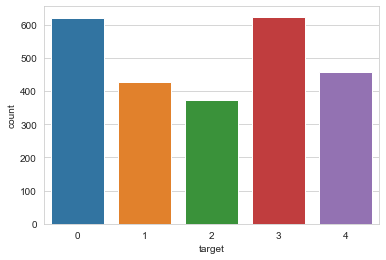

In [15]:
sns.countplot(data_test.target)

C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

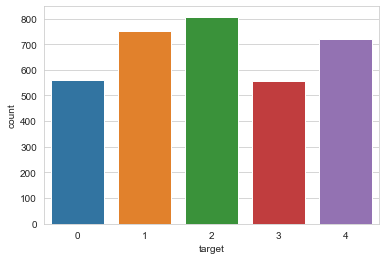

In [16]:
sns.countplot(data_train.target)

In [8]:
#### Training sets
x_train = data_train.iloc[:,:66]
y_train = data_train.iloc[:, 66:]

#### Testing sets
x_test = data_test.iloc[:, :66]
y_test = data_test.iloc[:, 66:]

In [17]:
x_train.head()

,time,activityrecognition_1,accelerometer_mean,accelerometer_min,accelerometer_max,accelerometer_std,game_rotation_vector_mean,game_rotation_vector_min,game_rotation_vector_max,game_rotation_vector_std,...,step_counter_max,step_counter_std,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std
0,45.0,100.0,9.950332,8.410105,11.997985,0.766395,0.969092,0.963024,0.980832,5.783952e-03,...,0.0,0.0,73.017802,73.017802,73.017802,0.053353,7.457659,7.457659,7.457659,0.00000
1,26.0,100.0,9.841642,8.433949,11.625431,0.757315,0.938011,0.936637,0.943838,1.966812e-03,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,10.476998,10.476998,10.476998,0.42211
2,201.0,38.0,9.724502,9.702260,9.874900,0.026175,0.999980,0.999980,0.999981,2.132909e-07,...,785.0,0.0,65.796237,65.796237,65.796237,14.022096,0.001865,0.001865,0.001865,0.00000
3,129.0,69.0,9.787588,9.100255,10.015627,0.145539,0.999196,0.998911,0.999577,2.352174e-04,...,6803.0,0.0,78.197536,78.197536,78.197536,3.843737,0.860946,0.860946,0.860946,0.00000
4,60.0,100.0,9.787193,9.741162,9.835721,0.022936,0.397271,0.394770,0.402063,2.399165e-03,...,9198.0,0.0,60.365686,60.365686,60.365686,1.487859,0.000000,0.000000,0.000000,0.00000


In [18]:
x_train['gyroscope_std']

0       0.034665
1       0.023221
2       0.000292
3       0.025989
4       0.316940
          ...   
3388    0.996347
3389    1.194949
3390    1.463428
3391    1.013326
3392    0.007948
Name: gyroscope_std, Length: 3393, dtype: float64

In [9]:
tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees": ExtraTreesClassifier(n_estimators=100),
  "Random Forest": RandomForestClassifier(n_estimators=100),
  "AdaBoost": AdaBoostClassifier(n_estimators=100),
  "Skl GBM": GradientBoostingClassifier(n_estimators=100),
  "Skl HistGBM": HistGradientBoostingClassifier(max_iter=100),
  "XGBoost": XGBClassifier(n_estimators=100),
  "LightGBM": LGBMClassifier(n_estimators=100),
  "CatBoost":  CatBoostClassifier(n_estimators=100),
}

In [10]:
tree_classifiers = {name: make_pipeline(model) for name, model in tree_classifiers.items()}

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

In [11]:
rang = abs(y_train.max()) + abs(y_train.min())
for model_name, model in tree_classifiers.items():
    
    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
        
    pred = model.predict(x_test)
    
    results = results.append({"Model":    model_name,
                              "Accuracy": accuracy_score(y_test, pred)*100,
                              "Bal Acc.": balanced_accuracy_score(y_test, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              
results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d 

[20:54:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Learning rate set to 0.5
0:	learn: 0.9057873	total: 215ms	remaining: 21.3s
1:	learn: 0.6710922	total: 251ms	remaining: 12.3s
2:	learn: 0.5424035	total: 288ms	remaining: 9.32s
3:	learn: 0.4550630	total: 325ms	remaining: 7.81s
4:	learn: 0.3865361	total: 362ms	remaining: 6.87s
5:	learn: 0.3369850	total: 399ms	remaining: 6.25s
6:	learn: 0.2856685	total: 435ms	remaining: 5.77s
7:	learn: 0.2573170	total: 475ms	remaining: 5.46s
8:	learn: 0.2339398	total: 511ms	remaining: 5.17s
9:	learn: 0.2121946	total: 554ms	remaining: 4.99s
10:	learn: 0.1960446	total: 594ms	remaining: 4.81s
11:	learn: 0.1823096	total: 635ms	remaining: 4.65s
12:	learn: 0.1637905	total: 674ms	remaining: 4.51s
13:	learn: 0.1540224	total: 716ms	remaining: 4.4s
14:	learn: 0.1430181	total: 753ms	remaining: 4.26s
15:	learn: 0.1349853	total: 791ms	remaining: 4.15s
16:	learn: 0.1312751	total: 827ms	remaining: 4.04s
17:	learn: 0.1276920	total: 862ms	remaining: 3.93s
18:	learn: 0.1203083	total: 902ms	remaining: 3.84s
19:	learn: 0.1135

,Model,Accuracy,Bal Acc.,Time
1,Extra Trees,64.560000,61.051512,0.342676
2,CatBoost,60.400000,62.262732,4.316001
3,Skl HistGBM,58.880000,59.810007,6.915471
4,Random Forest,58.360000,59.930332,0.966972
5,LightGBM,57.560000,59.037283,1.380309
6,XGBoost,53.760000,55.333157,2.013615
7,AdaBoost,50.480000,54.134368,1.577080
8,Skl GBM,47.720000,48.026208,17.127564
9,Decision Tree,46.880000,49.757551,0.143252


In [12]:
results_ord

,Model,Accuracy,Bal Acc.,Time
1,Extra Trees,64.56,61.051512,0.342676
2,CatBoost,60.40,62.262732,4.316001
3,Skl HistGBM,58.88,59.810007,6.915471
4,Random Forest,58.36,59.930332,0.966972
5,LightGBM,57.56,59.037283,1.380309
6,XGBoost,53.76,55.333157,2.013615
7,AdaBoost,50.48,54.134368,1.577080
8,Skl GBM,47.72,48.026208,17.127564
9,Decision Tree,46.88,49.757551,0.143252
